# **Machine Learning for Neuroimaging 2023 — Assignment 3**

## **ABIDE I Functional Connectome Analysis**

You have been provided with a resting-state fMRI connectome dataset of 120 individuals diagnosed with Autism Spectrum Disorder (ASD) and 120 typical controls. Each connectome, i.e., each subject’s brain network and properties, is encoded as an 𝑁-by-𝑁 correlation matrix 𝐌, where $M_{i,j}$ is the functional connectivity (correlation in activation patterns) between region $i$ and region $j$.

Note that this is the preprocessed version of ABIDE provided by the Preprocessed Connectome Project (PCP).

For more information about this dataset's structure: http://preprocessed-connectomes-project.org/abide/

*Cameron Craddock, Yassine Benhajali, Carlton Chu, Francois Chouinard, Alan Evans, András Jakab, Budhachandra Singh Khundrakpam, John David Lewis, Qingyang Li, Michael Milham, Chaogan Yan, Pierre Bellec (2013). The Neuro Bureau Preprocessing Initiative: open sharing of preprocessed neuroimaging data and derivatives. In Neuroinformatics 2013, Stockholm, Sweden.*

**Relevant Libraries**
*  [NumPy](https://numpy.org/):https For numerical computing and handling multi-dimensional data.
*  [Pandas](https://pandas.pydata.org/): For structured data operations and manipulations.
*  [Matplotlib](https://matplotlib.org/): For creating static, interactive, and animated visualizations in Python.
*  [scikit-learn](https://scikit-learn.org/stable/): For implementing machine learning algorithms.
*  [nibabel](https://nipy.org/nibabel/): For reading and writing neuroimaging data formats.
*  [nilearn](https://nilearn.github.io/stable/index.html): For advanced neuroimaging data manipulation and visualization.
*  [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/): For writing and training Graph Neural Networks (GNNs).
*  [DGL (Deep Graph Library)](https://www.dgl.ai/): For deep learning on GNNs.

In [52]:
# %%capture
# # @title Run to install needed packages.
# !pip install nilearn torch torchvision torchaudio torch-geometric

In [53]:
# @title Load parcellated, connectivity matrices as our features, X
import numpy as np
import pickle as pkl
from nilearn.connectome import ConnectivityMeasure

'''
Load the connectivity matrices
Note: each connectivity matrix (sample) was derived using the NiftiLabelsMasker
and ConnectivityMeasure [with full Pearson's correlation] from nilearn and each
sample was also standardized by z-score
[i.e., zero mean scaled to unit variance w.r.t. sample std]
'''

data_path = './ABIDE_240.npz'
# Load the data
data = np.load(data_path)

# Accessing the arrays
connectomes = data['features']
y_abide = data['labels']
print(connectomes[6].shape)
# print(f"y_abide: {y_abide}")

# seperate AD and control group
connectomes_ad = []
connectomes_control = []
for i in range(len(connectomes)):
    if y_abide[i] ==1:
        connectomes_ad.append(connectomes[i])
    elif y_abide[i] ==2:
        connectomes_control.append(connectomes[i])
print(f"Number of AD subjects: {len(connectomes_ad)}")
print(f"Number of control subjects: {len(connectomes_control)}")

print("Data loaded from NPZ file.")

# Check the number of subject functional scans fetched
print(f"Number of subjects: {len(connectomes)}")

(116, 116)
Number of AD subjects: 120
Number of control subjects: 120
Data loaded from NPZ file.
Number of subjects: 240


In [54]:
from nilearn import plotting
from nilearn import datasets

# Retrieve AAL brain atlas for parcellation, more info here: https://www.sciencedirect.com/science/article/pii/S1053811901909784
parcellations = datasets.fetch_atlas_aal()
atlas_filename = parcellations.maps
labels = parcellations.labels
print(f"Number of ROIs: {len(labels)}")

# # Plot atlas
# plotting.plot_roi(atlas_filename, draw_cross=False)

Number of ROIs: 116


## Q1.

Plot a random connectivity matrix from the dataset.

---

In [55]:
# cm_sample = connectomes[48]
# print(f"Connectivity matrix shape: {cm_sample.shape}")

# np.fill_diagonal(cm_sample, 0)

# plotting.plot_matrix(cm_sample, figure=(10, 8),
#                      labels=range(cm_sample.shape[-1]),
#                      vmax=0.8, vmin=-0.8, reorder=False)

The labels contain diagnostic group each participant is in. It is coded as:

*   1 = Autism Spectrum Disorder (ASD)
*   2 = Control

Let's re-index this to 0=ASD and 1=Control due to zero-indexed systems required for ML and other data processing software.

In [56]:
from collections import Counter

# Adjust labels to start from 0
y_abide = y_abide - 1

# Print label classes and counts
print(Counter(y_abide))

Counter({0: 120, 1: 120})


Now, you're ready to prepare the data for machine learning or statistical analysis.

Note: If you are interested in using graph neural networks, feel free to use the below PyG starter code to create your custom PyG (pytorch geometric) Dataset. Check the assignment description for links to related tutorials.

---

In [57]:
# import 
# @title [GraphML ONLY] Create custom PyG ConnectomeDataset
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import dense_to_sparse

In [58]:
class ConnectomeDataset(Dataset):
    def __init__(self, connectivity_matrices, labels, task="classification", transform=None, pre_transform=None):
        super(ConnectomeDataset, self).__init__(None, transform, pre_transform)
        self.connectivity_matrices = connectivity_matrices
        self.labels = labels
        self.task = task

    def len(self):
        return len(self.connectivity_matrices)

    def get(self, idx):
        # Convert the connectivity matrix to edge index and edge attributes
        connectivity_matrix = torch.tensor(self.connectivity_matrices[idx])
        edge_index, edge_attr = dense_to_sparse(connectivity_matrix)

        # Create a data object
        data = Data(edge_index=edge_index, edge_attr=edge_attr)
        data.x = connectivity_matrix.to(torch.float)
        if self.task == "classification":
          data.y = torch.tensor([self.labels[idx]], dtype=torch.long) # make labels start at 0
        else:
          data.y = torch.tensor([self.labels[idx]], dtype=torch.float)
        return data

### Example - GraphML Classification

In [59]:
# import 
import torch
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

In [60]:
# Instantiate the dataset
# print(y_abide)
abide_dataset = ConnectomeDataset(connectomes, y_abide)
print(abide_dataset)
loader = DataLoader(abide_dataset, batch_size=32, shuffle=True)
# for i in loader:
#     print(i.y)

print(f'abide_dataset info:')
print(f'Number of graphs: {len(abide_dataset)}')
print("class (y_abide): ", np.unique(y_abide, return_counts=True))
print("Number of node features: ", abide_dataset.num_node_features)
print(f'Number of edge features: {abide_dataset.num_edge_features}')

num_classes = 2

# TO DO: Define a Graph Neural Network model
#...
# Define a GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(abide_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # Apply global mean pooling to get a single vector for the whole graph
        x = global_mean_pool(x, batch=data.batch)
        # x = F.log_softmax(x, dim=1)

        return x

ConnectomeDataset(240)
abide_dataset info:
Number of graphs: 240
class (y_abide):  (array([0, 1], dtype=int64), array([120, 120], dtype=int64))
Number of node features:  116
Number of edge features: 1


In [61]:
# Initialize the model
GCN_model = GCN()
print(GCN_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model = GCN_model.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, GCN_model.parameters()),
            lr=0.01,
            weight_decay=0.0001
        )

GCN(
  (conv1): GCNConv(116, 16)
  (conv2): GCNConv(16, 2)
)


In [62]:
# Train the model
GCN_model.train()
loss_history =[]
accuracy_history = []

for epoch in range(500):
    # Initialize variables to track the loss and accuracy for each epoch
    epoch_loss = 0.0
    epoch_correct_predictions = 0
    epoch_total_predictions = 0

    # Loop over each batch from the data loader
    # print(loader)
    for batch in loader:
        # Move batch to device
        batch = batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        out = GCN_model(batch)
        # Calculate loss
        # print(batch.y)
        loss = criterion(out, batch.y)
        epoch_loss += loss.item()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update the weights
        optimizer.step()
        # Calculate the number of correct predictions
        _, pred = torch.max(out, 1)
        epoch_correct_predictions += (pred == batch.y).sum().item()
        epoch_total_predictions += batch.y.size(0)

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(loader)
    loss_history.append(epoch_loss)
    epoch_accuracy = epoch_correct_predictions / epoch_total_predictions
    accuracy_history.append(epoch_accuracy)

    if epoch % 10 == 0: # Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}')



Epoch 1, Loss: 0.726, Accuracy: 0.471
Epoch 11, Loss: 0.677, Accuracy: 0.575
Epoch 21, Loss: 0.667, Accuracy: 0.592
Epoch 31, Loss: 0.668, Accuracy: 0.558
Epoch 41, Loss: 0.628, Accuracy: 0.621
Epoch 51, Loss: 0.603, Accuracy: 0.667
Epoch 61, Loss: 0.577, Accuracy: 0.688
Epoch 71, Loss: 0.562, Accuracy: 0.696
Epoch 81, Loss: 0.519, Accuracy: 0.754
Epoch 91, Loss: 0.544, Accuracy: 0.729
Epoch 101, Loss: 0.509, Accuracy: 0.742
Epoch 111, Loss: 0.524, Accuracy: 0.729
Epoch 121, Loss: 0.485, Accuracy: 0.758
Epoch 131, Loss: 0.528, Accuracy: 0.721
Epoch 141, Loss: 0.496, Accuracy: 0.738
Epoch 151, Loss: 0.470, Accuracy: 0.779
Epoch 161, Loss: 0.479, Accuracy: 0.762
Epoch 171, Loss: 0.477, Accuracy: 0.762
Epoch 181, Loss: 0.451, Accuracy: 0.775
Epoch 191, Loss: 0.508, Accuracy: 0.750
Epoch 201, Loss: 0.421, Accuracy: 0.792
Epoch 211, Loss: 0.403, Accuracy: 0.808
Epoch 221, Loss: 0.428, Accuracy: 0.779
Epoch 231, Loss: 0.393, Accuracy: 0.821
Epoch 241, Loss: 0.501, Accuracy: 0.721
Epoch 251, 

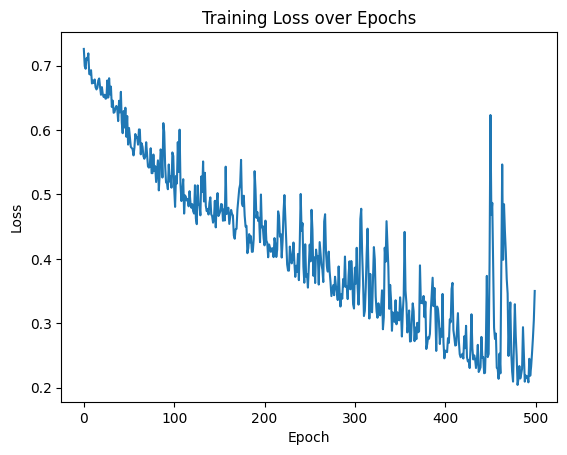

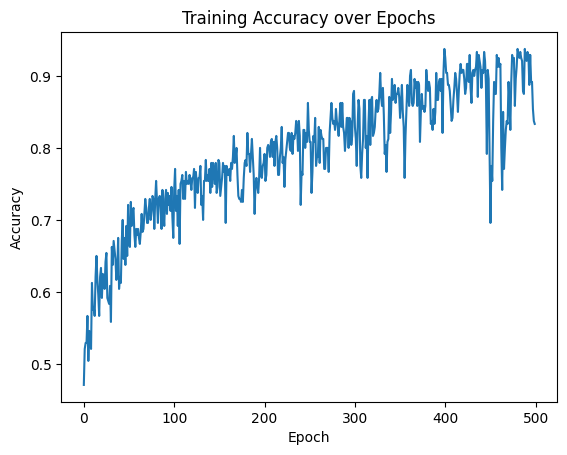

Final loss 0.35010620951652527, Final Accuracy: 0.8333333333333334


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn import datasets

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot training loss history over epochs
plt.plot(accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.show()

print(f'Final loss {loss_history[-1]}, Final Accuracy: {accuracy_history[-1]}')

In [ ]:
# Initialize the model
GCN_model = GCN()
print(GCN_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model = GCN_model.to(device)
data = dataset[0].to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Q2.

### Example - Graph Network Metrics

#### 1. Weight Distribution


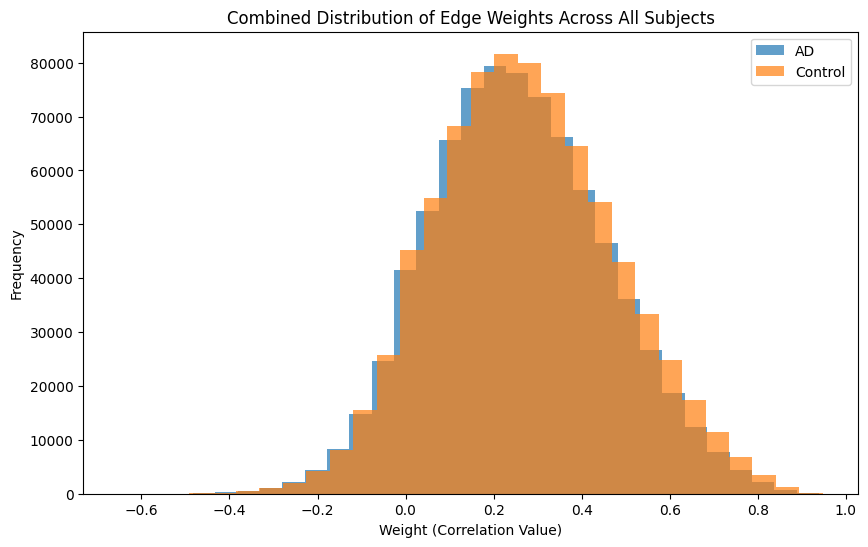

In [158]:
import numpy as np
import matplotlib.pyplot as plt

## --------------- all AD ------------------- ##
# Initialize an empty list to store weights from all connectomes
all_weights_ad = []

for cm_sample in connectomes_ad:
    # Extract the upper triangle weights for each connectome
    weights = cm_sample[np.triu_indices_from(cm_sample, k=1)]
    all_weights_ad.extend(weights)  # Add these weights to the list

# # Plotting the distribution of weights for all AD subjects
# plt.hist(all_weights_ad, bins=30, alpha=0.7)
# plt.title("Combined Distribution of Edge Weights Across All AD Subjects")
# plt.xlabel("Weight (Correlation Value)")
# plt.ylabel("Frequency")
# plt.show()


## --------------- all control ------------------- ##
# Initialize an empty list to store weights from all connectomes
all_weights_control = []

for cm_sample in connectomes_control:
    # Extract the upper triangle weights for each connectome
    weights = cm_sample[np.triu_indices_from(cm_sample, k=1)]
    all_weights_control.extend(weights)  # Add these weights to the list

# # Plotting the distribution of weights for all control subjects
# plt.hist(all_weights_control, bins=30, alpha=0.7)
# plt.title("Combined Distribution of Edge Weights Across All Control Subjects")
# plt.xlabel("Weight (Correlation Value)")
# plt.ylabel("Frequency")
# plt.show()

## ------------------ plot ALL -------------------
# Plotting the distribution of weights for all control subjects
plt.figure(figsize=(10, 6))
plt.hist(all_weights_ad, bins=30, alpha=0.7)
plt.hist(all_weights_control, bins=30, alpha=0.7)
plt.title("Combined Distribution of Edge Weights Across All Subjects")
plt.legend(['AD', 'Control'])
plt.xlabel("Weight (Correlation Value)")
plt.ylabel("Frequency")
plt.show()

# ## --------------- random subject ------------------- ##
# # Extract upper triangle to avoid duplication for both cohorts
# cm_sample = connectomes[46] # random single subject
# weights = cm_sample[np.triu_indices_from(cm_sample, k=1)]  # Extract upper triangle to avoid duplication

# # Plotting the distribution of weights
# plt.hist(weights, bins=30, alpha=0.7)
# plt.title("Distribution of Edge Weights")
# plt.xlabel("Weight (Correlation Value)")
# plt.ylabel("Frequency")
# plt.show()


#### k-s test for distribution of edge weight

In [159]:
from scipy.stats import ks_2samp

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(all_weights_ad, all_weights_control)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in the weighted degree distributions between the two cohorts.")
else:
    print("There is no significant difference in the weighted degree distributions between the two cohorts.")

KS statistic: 0.03234757621189405
P-value: 0.0
There is a significant difference in the weighted degree distributions between the two cohorts.


In [160]:
# Calculate mean, median, and standard deviation for the AD group
mean_ad = np.mean(all_weights_ad)
median_ad = np.median(all_weights_ad)
std_dev_ad = np.std(all_weights_ad)

# Calculate mean, median, and standard deviation for the Control group
mean_control = np.mean(all_weights_control)
median_control = np.median(all_weights_control)
std_dev_control = np.std(all_weights_control)

print(f"AD Group - Mean: {mean_ad}, Median: {median_ad}, Std Dev: {std_dev_ad}")
print(f"Control Group - Mean: {mean_control}, Median: {median_control}, Std Dev: {std_dev_control}")


AD Group - Mean: 0.25575953470894536, Median: 0.24727506706370617, Std Dev: 0.19988430133659624
Control Group - Mean: 0.27327169245845334, Median: 0.2639764616168946, Std Dev: 0.20533227353064304


### 2. Weighted Degree

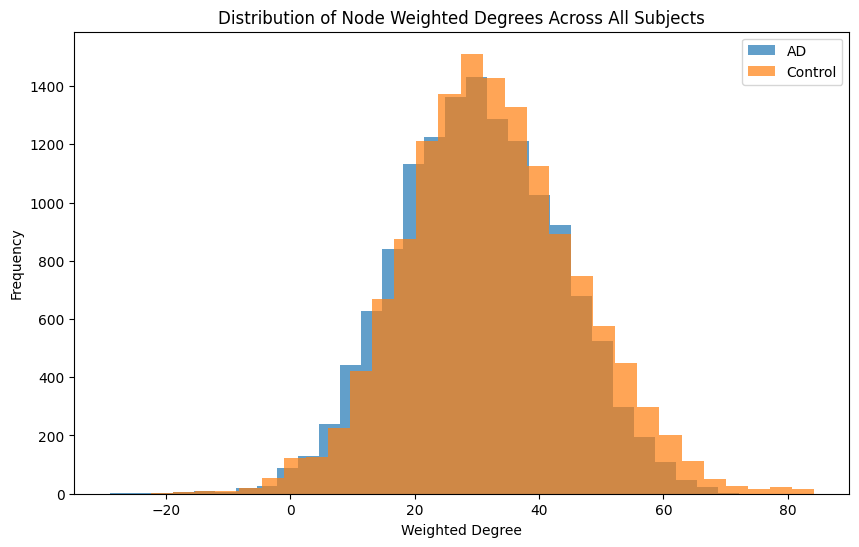

In [157]:
import numpy as np
import matplotlib.pyplot as plt

all_weighted_degrees_ad = []
for cm_sample in connectomes_ad:
    weighted_degrees = np.sum(cm_sample, axis=1)
    all_weighted_degrees_ad.extend(weighted_degrees)

all_weighted_degrees_control = []
for cm_sample in connectomes_control:
    weighted_degrees = np.sum(cm_sample, axis=1)
    all_weighted_degrees_control.extend(weighted_degrees)

# Plotting the distribution of weighted degrees across all control connectomes
plt.figure(figsize=(10, 6))
plt.hist(all_weighted_degrees_ad, bins=30, alpha=0.7)
plt.hist(all_weighted_degrees_control, bins=30, alpha=0.7)
plt.title("Distribution of Node Weighted Degrees Across All Subjects")
plt.legend(['AD', 'Control'])
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")
plt.show()


#### 2.1 k-s test for weighted degree distributions

In [68]:
from scipy.stats import ks_2samp

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(all_weighted_degrees_ad, all_weighted_degrees_control)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in the weighted degree distributions between the two cohorts.")
else:
    print("There is no significant difference in the weighted degree distributions between the two cohorts.")


KS statistic: 0.05193965517241378
P-value: 9.287999096676226e-17
There is a significant difference in the weighted degree distributions between the two cohorts.


In [69]:
# Calculate mean, median, and standard deviation for the AD group
mean_ad = np.mean(all_weighted_degrees_ad)
median_ad = np.median(all_weighted_degrees_ad)
std_dev_ad = np.std(all_weighted_degrees_ad)

# Calculate mean, median, and standard deviation for the Control group
mean_control = np.mean(all_weighted_degrees_control)
median_control = np.median(all_weighted_degrees_control)
std_dev_control = np.std(all_weighted_degrees_control)

print(f"AD Group - Mean: {mean_ad}, Median: {median_ad}, Std Dev: {std_dev_ad}")
print(f"Control Group - Mean: {mean_control}, Median: {median_control}, Std Dev: {std_dev_control}")


AD Group - Mean: 30.404013158195387, Median: 30.164230293400376, Std Dev: 13.013361855034226
Control Group - Mean: 32.42624463272214, Median: 31.675868757878817, Std Dev: 13.947880165710519


### 3. 


### Example - Network Community Detection
(community: maximally coherent network)

In [89]:
import networkx as nx
import numpy as np
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

from matplotlib import colormaps

'''Note: networkx expects non-negative edge weights for community detection;
convert connectome edge weights to absolute value (changes edge weight
information to strength only and not whether positively or negatively
correlated.)
'''
# # -------------------------------- AD ------------------------------------
# modularity_ad =[]
# for cm_sample in connectomes_ad:
#     # Find the absolute maximum value in the connectome for scaling
#     abs_cm_sample = np.abs(cm_sample)

#     G = nx.from_numpy_array(abs_cm_sample)

#     # Use the Louvain method for community detection
#     partition = community_louvain.best_partition(G)

#     # Visualize the communities
#     pos = nx.spring_layout(G)  # Positioning of the nodes
#     cmap = colormaps['viridis']

#     # for com in set(partition.values()):
#     #     list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
#     #     nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20,
#     #                         node_color=[cmap(com / (max(partition.values()) + 1))])
#     # nx.draw_networkx_edges(G, pos, alpha=0.5)
#     # plt.show()
#     modularity = community.modularity(partition, G)
#     modularity_ad.append(modularity)



120


In [145]:
# -------------------------------- AD ------------------------------------
modularity_ad =[]
community_stats_ad = []
for cm_sample in connectomes_ad:
    # Find the absolute maximum value in the connectome for scaling
    abs_cm_sample = np.abs(cm_sample)

    G = nx.from_numpy_array(abs_cm_sample)

    # Use the Louvain method for community detection
    partition = community_louvain.best_partition(G)

    # Calculate modularity and add to the list
    modularity = community.modularity(partition, G)
    modularity_ad.append(modularity)

    # Analyze the community structure
    community_structure = {}
    for community_id in set(partition.values()):
        nodes_in_community = [node for node, com in partition.items() if com == community_id]
        subgraph = G.subgraph(nodes_in_community)
        internal_edges = subgraph.size(weight='weight')
        external_edges = G.size(weight='weight') - internal_edges
        num_internal_edges = subgraph.number_of_edges()
        num_external_edges = G.number_of_edges() - num_internal_edges

        # Calculate the average weight of edges within this community
        avg_internal_weight = internal_edges / num_internal_edges if num_internal_edges else 0
        
        # Calculate the average weight of edges leaving this community
        avg_external_weight = external_edges / num_external_edges if num_external_edges else 0
        
        community_structure[community_id] = {
            'nodes': len(nodes_in_community),
            'avg_internal_weight': avg_internal_weight,
            'avg_external_weight': avg_external_weight
        }

    community_stats_ad.append(community_structure)

In [141]:
# -------------------------------- control ------------------------------------
modularity_control =[]
community_stats_control = []
for cm_sample in connectomes_control:
    # Find the absolute maximum value in the connectome for scaling
    abs_cm_sample = np.abs(cm_sample)

    G = nx.from_numpy_array(abs_cm_sample)

    # Use the Louvain method for community detection
    partition = community_louvain.best_partition(G)

    # Calculate modularity and add to the list
    modularity = community_louvain.modularity(partition, G)
    modularity_control.append(modularity)

    # Analyze the community structure
    community_structure = {}
    for community_id in set(partition.values()):
        nodes_in_community = [node for node, com in partition.items() if com == community_id]
        subgraph = G.subgraph(nodes_in_community)
        internal_edges = subgraph.size(weight='weight')
        external_edges = G.size(weight='weight') - internal_edges
        num_internal_edges = subgraph.number_of_edges()
        num_external_edges = G.number_of_edges() - num_internal_edges

        # Calculate the average weight of edges within this community
        avg_internal_weight = internal_edges / num_internal_edges if num_internal_edges else 0
        
        # Calculate the average weight of edges leaving this community
        avg_external_weight = external_edges / num_external_edges if num_external_edges else 0
        
        community_structure[community_id] = {
            'nodes': len(nodes_in_community),
            'avg_internal_weight': avg_internal_weight,
            'avg_external_weight': avg_external_weight
        }
    
    community_stats_control.append(community_structure)


##### Visualize Community Stat


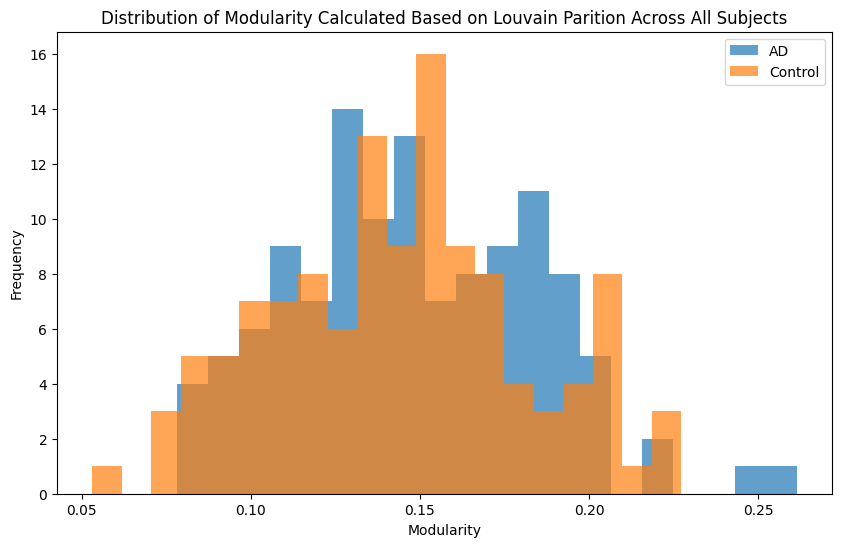

In [177]:
# modularity_ad_avg = np.average(modularity_ad)
# print(modularity_ad_avg)

# modularity_control_avg = np.average(modularity_control)
# print(modularity_control_avg)

# Plotting the distribution of weighted degrees across all control connectomes
plt.figure(figsize=(10, 6))
plt.hist(modularity_ad, bins=20, alpha=0.7)
plt.hist(modularity_control, bins=20, alpha=0.7)

plt.title("Distribution of Modularity Calculated Based on Louvain Parition Across All Subjects")
plt.legend(['AD', 'Control'])
plt.xlabel("Modularity")
plt.ylabel("Frequency")
plt.show()

#### k-s test for modularity

In [165]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(modularity_ad, modularity_control)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in the modularity between the two cohorts.")
else:
    print("There is no significant difference in the modularity between the two cohorts.")


KS statistic: 0.1
P-value: 0.5879759185183517
There is no significant difference in the modularity between the two cohorts.


##### Visualize Community Stat


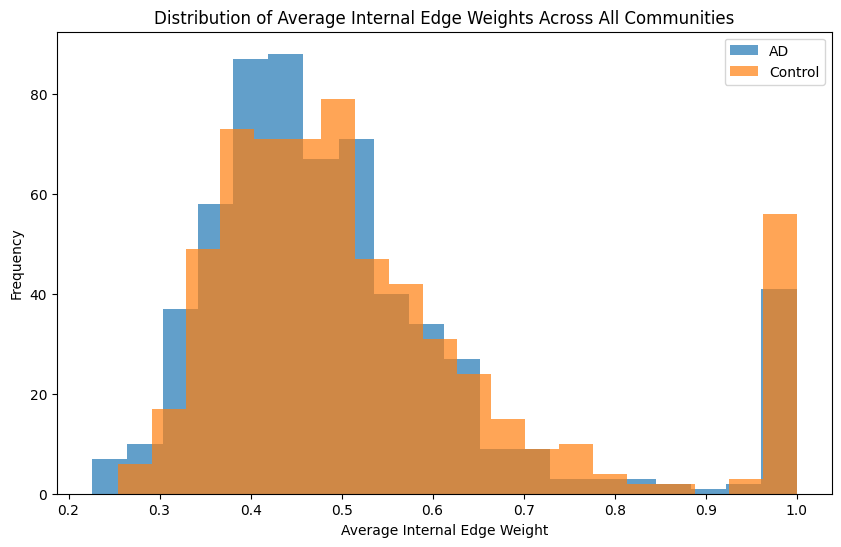

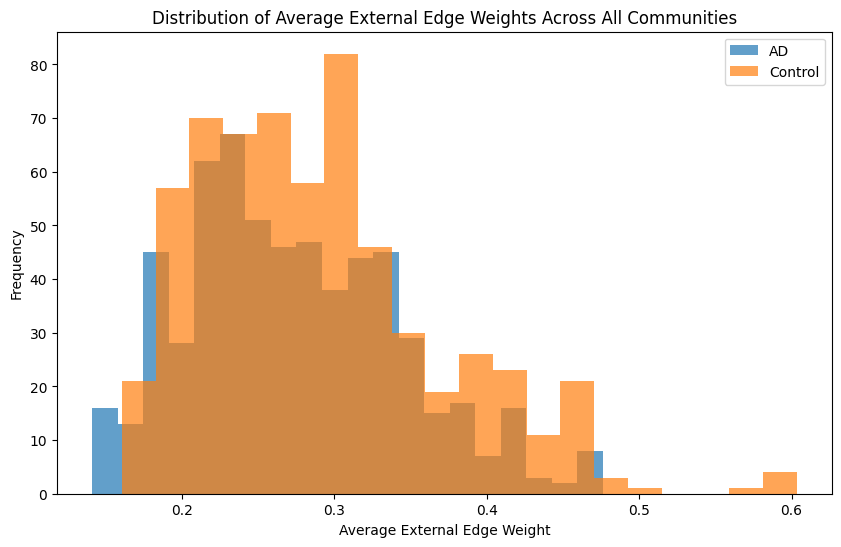

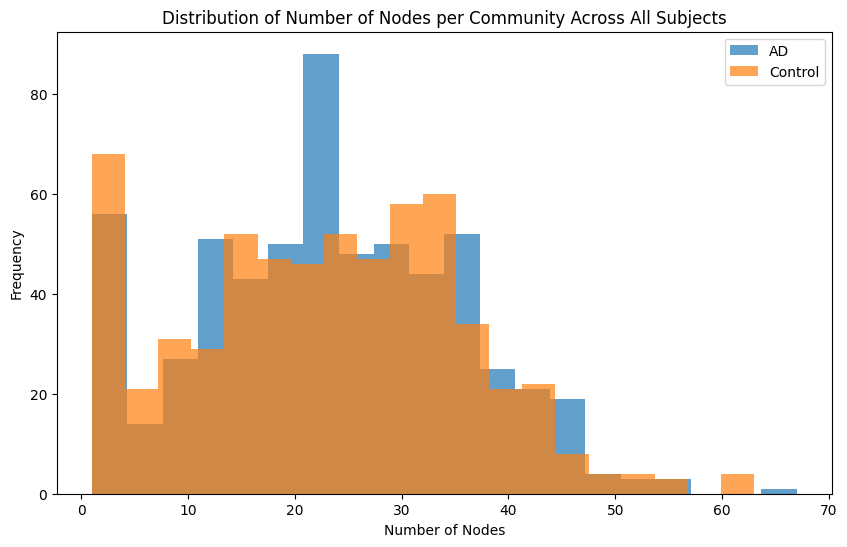

In [176]:
# Gather the average internal edge weights per community for each cohort
avg_internal_weights_control = [stat['avg_internal_weight'] for stats in community_stats_control for stat in stats.values()]
avg_internal_weights_ad = [stat['avg_internal_weight'] for stats in community_stats_ad for stat in stats.values()]

# Gather the average external edge weights per community for each cohort
avg_external_weights_control = [stat['avg_external_weight'] for stats in community_stats_control for stat in stats.values()]
avg_external_weights_ad = [stat['avg_external_weight'] for stats in community_stats_ad for stat in stats.values()]

# Gather the number of nodes per community for each cohort
nodes_per_community_control = [stat['nodes'] for stats in community_stats_control for stat in stats.values()]
nodes_per_community_ad = [stat['nodes'] for stats in community_stats_ad for stat in stats.values()]

# Plot for average internal edge weights
plt.figure(figsize=(10, 6))
plt.hist(avg_internal_weights_ad, bins=20, alpha=0.7, label='AD')
plt.hist(avg_internal_weights_control, bins=20, alpha=0.7, label='Control')
plt.title('Distribution of Average Internal Edge Weights Across All Communities')
plt.xlabel('Average Internal Edge Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot for average external edge weights
plt.figure(figsize=(10, 6))
plt.hist(avg_external_weights_ad, bins=20, alpha=0.7, label='AD')
plt.hist(avg_external_weights_control, bins=20, alpha=0.7, label='Control')
plt.title('Distribution of Average External Edge Weights Across All Communities')
plt.xlabel('Average External Edge Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot for the number of nodes per community
plt.figure(figsize=(10, 6))
plt.hist(nodes_per_community_ad, bins=20, alpha=0.7, label='AD')
plt.hist(nodes_per_community_control, bins=20, alpha=0.7, label='Control')
plt.title('Distribution of Number of Nodes per Community Across All Subjects')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### k-s test for comunity stat (internal weight)

In [169]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(avg_internal_weights_control, avg_internal_weights_ad)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in average internal edge weight between the two cohorts.")
else:
    print("There is no significant difference in average internal edge weight between the two cohorts.")


KS statistic: 0.08328938847888871
P-value: 0.027785065162438966
There is a significant difference in average internal edge weight between the two cohorts.


#### k-s test for comunity stat (external weight)

In [171]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(avg_external_weights_control, avg_external_weights_ad)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in average external edge weight between the two cohorts.")
else:
    print("There is no significant difference in average external edge weight between the two cohorts.")


KS statistic: 0.0876064581175937
P-value: 0.017703394774600006
There is a significant difference in average external edge weight between the two cohorts.


#### k-s test for comunity stat (number of node per community)

In [174]:
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(nodes_per_community_control, nodes_per_community_ad)

# Print the results
print("KS statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in number of node per community between the two cohorts.")
else:
    print("There is no significant difference in number of node per community between the two cohorts.")

KS statistic: 0.04120069182407122
P-value: 0.661166115745442
There is no significant difference in number of node per community between the two cohorts.
